# OOI Arrays: Overview and Context for CHLA Profiling
**Author:** Eli Holmes (NOAA)</br>
Last updated: Dec 5, 2025

The [Ocean Observatories Initiative (OOI)](https://oceanobservatories.org/) is a long-term, NSF-funded ocean observing program designed to provide continuous, high-resolution measurements across key regions of the global and coastal ocean.  
OOI systems collect physical, chemical, biological, and geological observations using a combination of:

- **Moorings: fixed location** (surface, mid-water, deep-water) — These are sensors at fixed discrete depths. CHLA is available only at those specific depths.

- **Depth Profiler systems: fixed location**  
  - **Wire-following profilers (WFPs)** — Provide high-resolution vertical depth profiles, sampling repeatedly up and down the water column.  
  - **Shallow profilers (SPs)** — Motorized profilers delivering dense CHLA depth profiles in the 0-200m range, often with higher sampling frequency than WFPs.  
  - **Deep profilers (DPs)** — Provide deep water (> 200m) vertical profiles.

- **Autonomous gliders: moving location** — Mobile platforms that execute repeated sawtooth depth profiles and produce full vertical CHLA measurements for each dive.

Across these platforms, OOI instruments collect high-frequency, vertically resolved biological measurements, including:
chlorophyll-a concentration, particulate organic matter & phytoplankton biomass, colored dissolved organic matter (CDOM), photosynthetically available radiation (PAR), sea water physical properties (temperature, salinity, and density), dissolved oxygen, nitrate, pH, pCO₂.  We are interested in modeling CHLA vertical depth profiles and will focus on the chlorophyll-a concentration measurement. OOI data is openly available through the OOI Data Portal and ERDDAP servers.


![](Supporting_files/ooi.jpg)



## OOI Regional Arrays

OOI consists of **two major coastal arrays**, a **regional cabled array**, and **four global open-ocean arrays**. Coastal arrays sample continental shelf, slope, and upwelling environments that exhibit strong seasonal biological and physical variability. These sites typically include vertically profiling platforms that provide **full or partial CHLA depth profiles** in the upper 0–200 m. Global Arrays observe key climate-relevant open-ocean regions and generally **do not include vertical profilers**, but they do provide **CHLA at fixed depths** within the 0–200 m zone, which can still be mapped into depth bins.

1. **Coastal Stations:**
    - **Endurance Array (Oregon & Washington)** — Samples an eastern boundary upwelling system across nearshore, shelf, and offshore environments. Platforms include surface and subsurface moorings (fixed-depth CHLA), **wire-following profilers** (0–200 m), **cabled shallow/deep profilers**, and autonomous gliders (0–200+ m profiles).
    - **Pioneer Array (Northwest Atlantic / Mid-Atlantic Bight)** — Observes cross-shelf and shelf-break frontal systems with strong biological gradients. Platforms include multi-tier moorings, surface buoys, gliders, and (in most years) **shallow profilers** that provided high-resolution 0–200 m CHLA profiles.
    - **Regional Cabled Array (Washington–Oregon offshore)** — Provides real-time power and data to offshore slope and deepwater nodes. Only the **cabled shallow profilers** contribute 0–200 m CHLA profiles; most deep or seafloor instruments do not sample CHLA.

2. **Global Stations:**
    - **Papa Array (Gulf of Alaska)** — Subarctic gyre; CHLA sensors at fixed depths (typically 7–50 m).
    - **Irminger Sea Array (Greenland–Iceland region)** — High-latitude convection region; CHLA at fixed depths in the upper 100 m.
    - **Argentine Basin Array (Southwest Atlantic)** — Deep-ocean circulation site; limited CHLA at one or two fixed depths (~30 m).
    - **Southern Ocean Array (South of Tasmania)** — High-mixing Southern Ocean environment; CHLA measurements at fixed depths in the upper 50 m.



## Workflow

This notebook processes CHLA data from OOI platforms showing:

- automated ERDDAP retrieval,  
- daily depth-binned CHLA profiles,  
- merged datasets across platforms and regions.

We work with a set of Endurance platforms listed in `endurance_dict`, including:

- **Offshore and shelf surface moorings** (near-surface instrument frames with fluorometers)
- **Cabled shallow and deep profilers**
- **Wire-following profilers** on offshore moorings
- **Inshore and shelf surface-piercing profilers**

For each platform, we:

1. Request CHLA data from the OOI ERDDAP server.
2. Process the data into **daily mean CHLA profiles** in fixed 10 m depth bins between 0 and 200 m.
3. Save per-platform parquet files and then merge them into a single, combined Endurance dataset.
4. Plot example CHLA–depth profiles for individual daily "profiles" (platform × day).


## Inspect ERDDAP variables for a single Endurance instrument

First, inspect the available variables for one representative dataset on the OOI ERDDAP server.  
This helps confirm the exact variable names for chlorophyll-a and related quality-control flags before building generalized code.


In [24]:
# See the variables
import pandas as pd
base = "https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap"
dataset_id = "ooi-ce04osps-sf01b-3a-flortd104"
header_url = f"{base}/{dataset_id}.csv?"
# read only the header, skip the units row
df0 = pd.read_csv(header_url, skiprows=[1], nrows=0)
print(df0.columns)

Index(['time', 'latitude', 'longitude', 'z',
       'concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate_profiler_depth_enabled',
       'concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate_profiler_depth_enabled_qc_agg',
       'concentration_of_colored_dissolved_organic_matter_in_sea_water_expressed_as_equivalent_mass_fraction_of_quinine_sulfate_dihydrate_profiler_depth_enabled_qc_tests',
       'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled',
       'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_agg',
       'mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_tests',
       'depth_reading_profiler_depth_enabled',
       'depth_reading_profiler_depth_enabled_qc_agg',
       'depth_reading_profiler_depth_enabled_qc_tests',
       'flubsct_profiler_depth_

## Prototype daily CHLA binning and profile plotting for one mooring

Here we prototype the workflow for **one Endurance instrument**:

- Request time series from ERDDAP.
- Convert depth from `z` (altitude, negative down) to positive meters.
- Filter to the 0–200 m range.
- Bin CHLA into 10 m depth bins (0–10, 10–20, …, 190–200 m).
- Aggregate to daily means per depth bin.
- Pick one daily profile and plot **CHLA vs depth**.


In [4]:
# See a dataframe with the variables we want
import pandas as pd
import os
import numpy as np
dataset_id = "ooi-ce04osps-sf01b-3a-flortd104"
chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled"
url = (
    "https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/"
    f"{dataset_id}.csv?"
    "time%2Clatitude%2Clongitude%2Cz%2C"
    f"{chl_var}%2C"
    f"{chl_var}_qc_agg"
    "&time%3E=2024-03-01"
    "&time%3C=2025-12-05T00%3A00%3A00Z"
    "&z%3E=-200"
)
df = pd.read_csv(url, skiprows=[1])
df["depth"] = -df["z"]    
qc_col = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_agg"
mask = (df["depth"] >= 0) & (df["depth"] < 200) & (df[qc_col] == 1.0)
df_good = df[mask].copy()
df_good

,time,latitude,longitude,z,mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled,mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled_qc_agg,depth
0,2024-03-01T00:00:00Z,44.369353,-124.954108,-161.0,0.033150,1,161.0
1,2024-03-01T00:01:00Z,44.369353,-124.954108,-161.0,0.030857,1,161.0
2,2024-03-01T00:02:00Z,44.369353,-124.954108,-161.0,0.037528,1,161.0
3,2024-03-01T00:03:00Z,44.369353,-124.954108,-161.0,0.038779,1,161.0
4,2024-03-01T00:04:00Z,44.369353,-124.954108,-161.0,0.022100,1,161.0
...,...,...,...,...,...,...,...
2350658,2025-12-04T23:56:00Z,44.369353,-124.954108,-192.0,0.047337,1,192.0
2350659,2025-12-04T23:57:00Z,44.369353,-124.954108,-192.0,0.046868,1,192.0
2350660,2025-12-04T23:58:00Z,44.369353,-124.954108,-192.0,0.049680,1,192.0
2350661,2025-12-04T23:59:00Z,44.369353,-124.954108,-192.0,0.049446,1,192.0


## Define a reusable function to fetch and bin CHLA from ERDDAP

Next we wrap the ERDDAP access and daily-binning logic into a reusable helper:

`ooi_mooring_save_file(url, description, id, save, out_dir)`

This function:

- Downloads CHLA (and QC flags, when available) from ERDDAP for a given dataset.
- Converts depths to positive meters and filters to 0–200 m.
- Computes **daily mean CHLA** in 10 m depth bins.
- Ensures all CHLA depth-bin columns (e.g., `CHLA_0_10`, …, `CHLA_190_200`) are present.
- Adds metadata such as latitude, longitude, description, and dataset ID.
- Optionally saves the daily profiles to a parquet file for that platform.


In [8]:
# Get and save a file
import numpy as np
import pandas as pd
from pathlib import Path
from urllib.parse import urlparse
import os

def ooi_mooring_save_file(url, description=None, chl_var="mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled",
                          id=None, save=False, out_dir=Path("_temp_data/ooi")):

    df = pd.read_csv(url, skiprows=[1])

    qc_col = f"{chl_var}_qc_agg"
    
    # Rename CHLA columns
    df = df.rename(columns={
        chl_var: "CHLA",
    })
    
    chla_col = "CHLA"
    
    # Time + date
    df["time"] = pd.to_datetime(df["time"])
    df["date"] = df["time"].dt.floor("D")
    
    # Depth (positive down)
    df["depth"] = -df["z"]
    
    # Filter 0–200 m and QC
    mask = (df["depth"] >= 0) & (df["depth"] < 200) & (df[qc_col] == 1.0)
    df_good = df[mask].copy()
    
    # 10 m bins
    bins = np.arange(0, 210, 10)  # 0,10,...,200
    labels = [f"{b}-{b+10}" for b in bins[:-1]]
    
    df_good["depth_bin"] = pd.cut(
        df_good["depth"],
        bins=bins,
        labels=labels,
        right=False,
    )
    
    # ---- PER-DAY × DEPTH-BIN AGGREGATION (with lat/lon) ----
    grp = (
        df_good
        .groupby(["date", "depth_bin"], observed=True)
        .agg(
            lat=("latitude", "first"),
            lon=("longitude", "first"),
            chla=(chla_col, "mean"),
        )
        .reset_index()
    )
    
    # ---- PIVOT TO WIDE FORM ----
    wide = grp.pivot(
        index=["date", "lat", "lon"],
        columns="depth_bin",
        values="chla",
    ).reset_index()
    
    # Rename depth-bin columns "0-10" → "chla_0_10"
    wide.columns = [
        ("CHLA_" + str(c).replace("-", "_")) if c not in ("date", "lat", "lon") else c
        for c in wide.columns
    ]
    
    # rename date → time
    wide = wide.rename(columns={"date": "time"})

    if description is not None:
        wide["description"]=description

    if save:
        parsed = urlparse(url)
        path = parsed.path
        filename = os.path.basename(path)         # 'ooi-ce04osps-sf01b-3a-flortd104.csv'
        dataset_id = filename.split('.')[0]       # 'ooi-ce04osps-sf01b-3a-flortd104'
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = f"{out_dir}/{dataset_id}.parquet"
        wide.to_parquet(out_path)
        return wide, out_path
    
    return wide, None

## Define OOI platforms of interest

Here we list the OOI platforms we want to process.

Each key in `ooi_dict` is an ERDDAP `dataset_id` on `https://erddap.dataexplorer.oceanobservatories.org/erddap`, and each value is a human-readable description of the mooring or profiler (location and instrument type, e.g., 3-wavelength fluorometer).

In [9]:
# The files we want
ooi_dict = {
    "ooi-ce04ossm-rid27-02-flortd000": "Coastal Endurance: Oregon Offshore Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-ce04osps-sf01b-3a-flortd104": "Coastal Endurance: Oregon Offshore Cabled Shallow Profiler Mooring: Shallow Profiler (SF01B): 3-Wavelength Fluorometer",
    "ooi-ce09ospm-wfp01-04-flortk000": "Coastal Endurance: Washington Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-ce01issp-sp001-08-flortj000": "Coastal Endurance: Oregon Inshore Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-ce04ospd-dp01b-04-flntua103": "Coastal Endurance: Oregon Offshore Cabled Deep Profiler Mooring: Wire-Following Profiler (DP01B): 2-Wavelength Fluorometer",
    "ooi-ce02shsp-sp001-07-flortj000": "Coastal Endurance: Oregon Shelf Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-ce02shsp-sp002-07-flortj000": "Coastal Endurance: Oregon Shelf Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer B",
    "ooi-ce06issp-sp001-08-flortj000": "Coastal Endurance: Washington Inshore Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-ce07shsp-sp001-07-flortj000": "Coastal Endurance: Washington Shelf Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-cp10cnsm-rid27-02-flortd000": "Coastal Pioneer MAB: Central Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp13eapm-wfp01-04-flortk000": "Coastal Pioneer MAB: Eastern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp14nepm-wfp01-04-flortk000": "Coastal Pioneer MAB: Northeastern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp13nopm-wfp01-04-flortk000": "Coastal Pioneer MAB: Northern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp11nosm-rid27-02-flortd000": "Coastal Pioneer MAB: Northern Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp14sepm-wfp01-04-flortk000": "Coastal Pioneer MAB: Southeastern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp13sopm-wfp01-04-flortk000": "Coastal Pioneer MAB: Southern Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp11sosm-rid27-02-flortd000": "Coastal Pioneer MAB: Southern Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp02pmci-wfp01-04-flortk000": "Coastal Pioneer NES: Central Inshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp02pmco-wfp01-04-flortk000": "Coastal Pioneer NES: Central Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp01cnpm-wfp01-04-flortk000": "Coastal Pioneer NES: Central Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp01cnsm-rid27-02-flortd000": "Coastal Pioneer NES: Central Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp01cnsp-sp001-09-flortj000": "Coastal Pioneer NES: Central Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-cp03ispm-wfp01-04-flortk000": "Coastal Pioneer NES: Inshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp03issm-rid27-02-flortd000": "Coastal Pioneer NES: Inshore Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp03issp-sp001-09-flortj000": "Coastal Pioneer NES: Inshore Surface Piercing Profiler Mooring: Surface Piercing Profiler: 3-Wavelength Fluorometer",
    "ooi-cp04ospm-wfp01-04-flortk000": "Coastal Pioneer NES: Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp04ossm-rid27-02-flortd000": "Coastal Pioneer NES: Offshore Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-cp02pmui-wfp01-04-flortk000": "Coastal Pioneer NES: Upstream Inshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-cp02pmuo-wfp01-04-flortk000": "Coastal Pioneer NES: Upstream Offshore Profiler Mooring: Wire-Following Profiler: 3-Wavelength Fluorometer",
    "ooi-rs03axps-pc03a-4c-flordd303": "Regional Cabled Array: Axial Base Shallow Profiler Mooring: 200m Platform (PC03A): 2-Wavelength Fluorometer",
    "ooi-rs03axps-sf03a-3a-flortd301": "Regional Cabled Array: Axial Base Shallow Profiler Mooring: Shallow Profiler (SF03A): 3-Wavelength Fluorometer",
    "ooi-rs01sbpd-dp01a-04-flntua102": "Regional Cabled Array: Oregon Slope Base Deep Profiler Mooring: Wire-Following Profiler (DP01A): 2-Wavelength Fluorometer",
    "ooi-rs01sbps-pc01a-4c-flordd103": "Regional Cabled Array: Oregon Slope Base Shallow Profiler Mooring: 200m Platform (PC01A): 2-Wavelength Fluorometer",
    "ooi-rs01sbps-sf01a-3a-flortd101": "Regional Cabled Array: Oregon Slope Base Shallow Profiler Mooring: Shallow Profiler (SF01A): 3-Wavelength Fluorometer",
    "ooi-gp02hypm-wfp03-01-flordl000": "Global Station Papa: Apex Profiler Mooring: Wire-Following Profiler Lower: 2-Wavelength Fluorometer",
    "ooi-gp02hypm-wfp02-01-flordl000": "Global Station Papa: Apex Profiler Mooring: Wire-Following Profiler Upper: 2-Wavelength Fluorometer",
    "ooi-gp03flma-ris01-05-flortd000": "Global Station Papa: Flanking Subsurface Mooring A: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gp03flmb-ris01-05-flortd000": "Global Station Papa: Flanking Subsurface Mooring B: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gi02hypm-wfp02-01-flordl000": "Global Irminger Sea: Apex Profiler Mooring: Wire-Following Profiler Upper: 2-Wavelength Fluorometer",
    "ooi-gi01sumo-rii11-02-flordg033": "Global Irminger Sea: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (130 meters)",
    "ooi-gi01sumo-rii11-02-flordg031": "Global Irminger Sea: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (40 meters)",
    "ooi-gi01sumo-rii11-02-flordg032": "Global Irminger Sea: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (80 meters)",
    "ooi-gi01sumo-rid16-02-flortd000": "Global Irminger Sea: Apex Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-gi01sumo-sbd12-02-flortd000": "Global Irminger Sea: Apex Surface Mooring: Surface Buoy: 3-Wavelength Fluorometer",
    "ooi-gi03flma-ris01-05-flortd000": "Global Irminger Sea: Flanking Subsurface Mooring A: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gi03flmb-ris01-05-flortd000": "Global Irminger Sea: Flanking Subsurface Mooring B: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-ga02hypm-wfp03-01-flordl000": "Global Argentine Basin: Apex Profiler Mooring: Wire-Following Profiler Lower: 2-Wavelength Fluorometer",
    "ooi-ga02hypm-wfp02-01-flordl000": "Global Argentine Basin: Apex Profiler Mooring: Wire-Following Profiler Upper: 2-Wavelength Fluorometer",
    "ooi-ga01sumo-rii11-02-flordg033": "Global Argentine Basin: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (130 meters)",
    "ooi-ga01sumo-rii11-02-flordg031": "Global Argentine Basin: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (40 meters)",
    "ooi-ga01sumo-rii11-02-flordg032": "Global Argentine Basin: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (80 meters)",
    "ooi-ga01sumo-rid16-02-flortd000": "Global Argentine Basin: Apex Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-ga01sumo-sbd12-02-flortd000": "Global Argentine Basin: Apex Surface Mooring: Surface Buoy: 3-Wavelength Fluorometer",
    "ooi-ga03flma-ris01-05-flortd000": "Global Argentine Basin: Flanking Subsurface Mooring A: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-ga03flmb-ris01-05-flortd000": "Global Argentine Basin: Flanking Subsurface Mooring B: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gs02hypm-wfp03-01-flordl000": "Global Southern Ocean: Apex Profiler Mooring: Wire-Following Profiler Lower: 2-Wavelength Fluorometer",
    "ooi-gs02hypm-wfp02-01-flordl000": "Global Southern Ocean: Apex Profiler Mooring: Wire-Following Profiler Upper: 2-Wavelength Fluorometer",
    "ooi-gs01sumo-rii11-02-flordg033": "Global Southern Ocean: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (130 meters)",
    "ooi-gs01sumo-rii11-02-flordg031": "Global Southern Ocean: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (40 meters)",
    "ooi-gs01sumo-rii11-02-flordg032": "Global Southern Ocean: Apex Surface Mooring: Mooring Riser: 2-Wavelength Fluorometer (80 meters)",
    "ooi-gs01sumo-rid16-02-flortd000": "Global Southern Ocean: Apex Surface Mooring: Near Surface Instrument Frame: 3-Wavelength Fluorometer",
    "ooi-gs01sumo-sbd12-02-flortd000": "Global Southern Ocean: Apex Surface Mooring: Surface Buoy: 3-Wavelength Fluorometer",
    "ooi-gs03flma-ris01-05-flortd000": "Global Southern Ocean: Flanking Subsurface Mooring A: Mooring Riser: 3-Wavelength Fluorometer",
    "ooi-gs03flmb-ris01-05-flortd000": "Global Southern Ocean: Flanking Subsurface Mooring B: Mooring Riser: 3-Wavelength Fluorometer",
}

## Read data from ERDDAP and save per-platform daily CHLA files

This (optional) cell loops over all platforms in `endurance_dict` and:

- Builds an ERDDAP URL for each dataset.
- Calls `ooi_mooring_save_file(...)` to:
  - Download CHLA data.
  - Process it into daily 10 m-binned profiles.
  - Save the result as a parquet file in `_temp_data/ooi/`.

The cell is wrapped in `%%script false` so it will **not** run by default;  
uncomment it when you are ready to download data.


In [57]:
%%script false --no-raise-error
# comment to run
from pathlib import Path

out_dir = Path("_temp_data/ooi")
out_dir.mkdir(parents=True, exist_ok=True)

mooring_chl = ["ooi-ce04ossm-rid27-02-flortd000", 
               "ooi-cp10cnsm-rid27-02-flortd000",
               "ooi-cp11nosm-rid27-02-flortd000",
               "ooi-cp11sosm-rid27-02-flortd000",
               "ooi-cp01cnsm-rid27-02-flortd000",
               "ooi-cp03issm-rid27-02-flortd000",
               "ooi-cp04ossm-rid27-02-flortd000",
               "ooi-rs03axps-pc03a-4c-flordd303",
               "ooi-rs01sbps-pc01a-4c-flordd103",
               "ooi-gp03flma-ris01-05-flortd000",
               "ooi-gp03flmb-ris01-05-flortd000",
              "ooi-gi01sumo-rii11-02-flordg033",
              "ooi-gi01sumo-rii11-02-flordg031",
              "ooi-gi01sumo-rii11-02-flordg032",
              "ooi-gi01sumo-rid16-02-flortd000",
              "ooi-gi01sumo-sbd12-02-flortd000",
               "ooi-gi03flma-ris01-05-flortd000",
               "ooi-gi03flmb-ris01-05-flortd000",
               "ooi-ga01sumo-rii11-02-flordg033",
               "ooi-ga01sumo-rii11-02-flordg031",
               "ooi-ga01sumo-rii11-02-flordg032",
               "ooi-ga01sumo-rid16-02-flortd000",
               "ooi-ga01sumo-sbd12-02-flortd000",
               "ooi-ga03flma-ris01-05-flortd000",
               "ooi-ga03flmb-ris01-05-flortd000",
                "ooi-gs01sumo-rii11-02-flordg033",
               "ooi-gs01sumo-rii11-02-flordg031",
               "ooi-gs01sumo-rii11-02-flordg032",
               "ooi-gs01sumo-rid16-02-flortd000",
               "ooi-gs01sumo-sbd12-02-flortd000",
               "ooi-gs03flma-ris01-05-flortd000",
               "ooi-gs03flmb-ris01-05-flortd000",
              ]

for dataset_id, desc in ooi_dict.items():
    # choose chlorophyll variable name
    if dataset_id in mooring_chl:
        chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water"
    else:
        chl_var = "mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled"

    # expected parquet path for this dataset
    out_path = out_dir / f"{dataset_id}.parquet"

    # skip if file already exists
    if out_path.exists():
        print(f"Skipping {dataset_id}: {out_path} already exists")
        continue

    bad = [
            "ooi-cp02pmci-wfp01-04-flortk000", # no data in time range
            "ooi-cp02pmco-wfp01-04-flortk000", # no data in time range
            "ooi-cp01cnpm-wfp01-04-flortk000", # no data in time range
            "ooi-cp01cnsm-rid27-02-flortd000", # no data in time range
            "ooi-cp01cnsp-sp001-09-flortj000", # no data in time range
            "ooi-cp03ispm-wfp01-04-flortk000", # no data in time range
            "ooi-cp03issm-rid27-02-flortd000", # no data in time range
            "ooi-cp03issp-sp001-09-flortj000", # no data in time range
            "ooi-cp04ospm-wfp01-04-flortk000", # no data in time range
            "ooi-cp04ossm-rid27-02-flortd000", # no data in time range
            "ooi-cp02pmui-wfp01-04-flortk000", # no data in time range
            "ooi-cp02pmuo-wfp01-04-flortk000", # no data in time range
            "ooi-rs01sbpd-dp01a-04-flntua102", # no data in time range
            "ooi-ga02hypm-wfp03-01-flordl000", # no data in time range
            "ooi-ga02hypm-wfp02-01-flordl000", # no data in time range
            "ooi-ga01sumo-rii11-02-flordg033", # no data in time range
            "ooi-ga01sumo-rii11-02-flordg031", # no data in time range
            "ooi-ga01sumo-rii11-02-flordg032", # no data in time range
            "ooi-ga01sumo-rid16-02-flortd000", # no data in time range
            "ooi-ga01sumo-sbd12-02-flortd000", # no data in time range
            "ooi-ga03flma-ris01-05-flortd000", # no data in time range
            "ooi-ga03flmb-ris01-05-flortd000", # no data in time range
            "ooi-gs02hypm-wfp03-01-flordl000", # no data in time range
            "ooi-gs02hypm-wfp02-01-flordl000", # no data in time range
            "ooi-gs01sumo-rii11-02-flordg033", # no data in time range
            "ooi-gs01sumo-rii11-02-flordg031", # no data in time range
            "ooi-gs01sumo-rii11-02-flordg032", # no data in time range
            "ooi-gs01sumo-rid16-02-flortd000", # no data in time range
            "ooi-gs01sumo-sbd12-02-flortd000", # no data in time range
            "ooi-gs03flma-ris01-05-flortd000", # no data in time range
            "ooi-gs03flmb-ris01-05-flortd000", # no data in time range
            "ooi-ce02shsp-sp002-07-flortj000", # no qc
            "ooi-rs01sbps-pc01a-4c-flordd103", # no qc
            "ooi-gp02hypm-wfp03-01-flordl000", # 2000m and deeper
          ]
    # build URL (special case without qc_agg)
    if dataset_id in bad :
        continue
    else:
        url = (
            "https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/"
            f"{dataset_id}.csv?"
            "time%2Clatitude%2Clongitude%2Cz%2C"
            f"{chl_var}%2C"
            f"{chl_var}_qc_agg"
            "&time%3E=2024-03-01"
            "&time%3C=2025-12-05T00%3A00%3A00Z"
            "&z%3E=-200"
        )

    print(f"Trying {dataset_id} with {url}")

    df, saved_path = ooi_mooring_save_file(
        url,
        description=desc,
        chl_var = chl_var,
        id=dataset_id,
        save=True,
        out_dir=out_dir,
    )
    print(f"Saved {dataset_id} ({desc}) to {saved_path}")



Skipping ooi-ce04ossm-rid27-02-flortd000: _temp_data/ooi/ooi-ce04ossm-rid27-02-flortd000.parquet already exists
Skipping ooi-ce04osps-sf01b-3a-flortd104: _temp_data/ooi/ooi-ce04osps-sf01b-3a-flortd104.parquet already exists
Skipping ooi-ce09ospm-wfp01-04-flortk000: _temp_data/ooi/ooi-ce09ospm-wfp01-04-flortk000.parquet already exists
Skipping ooi-ce01issp-sp001-08-flortj000: _temp_data/ooi/ooi-ce01issp-sp001-08-flortj000.parquet already exists
Skipping ooi-ce04ospd-dp01b-04-flntua103: _temp_data/ooi/ooi-ce04ospd-dp01b-04-flntua103.parquet already exists
Skipping ooi-ce02shsp-sp001-07-flortj000: _temp_data/ooi/ooi-ce02shsp-sp001-07-flortj000.parquet already exists
Skipping ooi-ce06issp-sp001-08-flortj000: _temp_data/ooi/ooi-ce06issp-sp001-08-flortj000.parquet already exists
Skipping ooi-ce07shsp-sp001-07-flortj000: _temp_data/ooi/ooi-ce07shsp-sp001-07-flortj000.parquet already exists
Skipping ooi-cp10cnsm-rid27-02-flortd000: _temp_data/ooi/ooi-cp10cnsm-rid27-02-flortd000.parquet already

## Inspect a single saved daily CHLA file

After running the ERDDAP download step, inspect one parquet file to verify:

- CHLA depth-bin columns are present and look reasonable.
- Time, latitude, and longitude are as expected for the platform.


In [69]:
# Examine the file
from pathlib import Path
import pandas as pd
out_dir = Path("_temp_data/ooi")
dataset_id = "ooi-ce01issp-sp001-08-flortj000"
out_path = f"{out_dir}/{dataset_id}.parquet"
df = pd.read_parquet(out_path)
df.head()

,time,lat,lon,CHLA_0_10,CHLA_10_20,CHLA_20_30,description
0,2024-04-11 00:00:00+00:00,44.65845,-124.0979,1.248099,1.369662,1.073702,Coastal Endurance: Oregon Inshore Surface Pier...
1,2024-04-12 00:00:00+00:00,44.65845,-124.0979,1.285849,1.286291,0.988821,Coastal Endurance: Oregon Inshore Surface Pier...
2,2024-04-17 00:00:00+00:00,44.65845,-124.0979,0.384099,0.510783,0.457698,Coastal Endurance: Oregon Inshore Surface Pier...
3,2024-04-18 00:00:00+00:00,44.65845,-124.0979,0.330928,0.311356,0.278780,Coastal Endurance: Oregon Inshore Surface Pier...
4,2024-04-19 00:00:00+00:00,44.65845,-124.0979,0.384770,0.366793,0.327334,Coastal Endurance: Oregon Inshore Surface Pier...


## Merge all platforms into a single OOI CHLA dataset

Here we:

- Read all per-platform parquet files from `_temp_data/ooi/`.
- Ensure that each file has **all** CHLA depth-bin columns (`CHLA_0_10`, …, `CHLA_190_200`), filling missing bins with `NaN`.
- Add a `profile_id` of the form `datasetID_YYYYMMDD` so each daily profile is uniquely identified by **platform × day**.
- Concatenate all platforms into a single dataframe and sort rows by time.
- Save the merged dataset to `_temp_data/ooi_chla_0_200m.parquet`.


In [73]:
#%%script false --no-raise-error
import numpy as np
import pandas as pd
from pathlib import Path

# directory where individual mooring parquet files live
out_dir = Path("_temp_data/ooi")

# all the CHLA columns you want to guarantee
chla_bins = [f"CHLA_{b}_{b+10}" for b in range(0, 200, 10)]

dfs = []

for p in out_dir.glob("*.parquet"):
    df = pd.read_parquet(p)

    # dataset_id from filename, e.g. "ooi-ce04osps-sf01b-3a-flortd104"
    dataset_id = p.stem

    # ensure time is datetime and make a date column
    df["time"] = pd.to_datetime(df["time"])
    date = df["time"].dt.floor("D")

    # profile_id = dataset_id_YYYYMMDD
    df["profile_id"] = dataset_id + "_" + date.dt.strftime("%Y%m%d")

    # ensure all CHLA_* columns exist
    for col in chla_bins:
        if col not in df.columns:
            df[col] = np.nan

    # consistent column order
    base_cols = ["profile_id", "time", "lat", "lon"]
    all_chla_cols = chla_bins
    other_cols = [c for c in df.columns if c not in base_cols + all_chla_cols]

    df = df[base_cols + all_chla_cols + other_cols]

    dfs.append(df)

# combine all rows
combined = pd.concat(dfs, ignore_index=True)

# sort by time (date) across all platforms
combined["time"] = pd.to_datetime(combined["time"])
combined = combined.sort_values("time").reset_index(drop=True)

# optional: save
combined_out = Path("_temp_data/ooi_chla_0_200m.parquet")
combined.to_parquet(combined_out)

combined.head()



,profile_id,time,lat,lon,CHLA_0_10,CHLA_10_20,CHLA_20_30,CHLA_30_40,CHLA_40_50,CHLA_50_60,...,CHLA_110_120,CHLA_120_130,CHLA_130_140,CHLA_140_150,CHLA_150_160,CHLA_160_170,CHLA_170_180,CHLA_180_190,CHLA_190_200,description
0,ooi-ce04ossm-rid27-02-flortd000_20240301,2024-03-01 00:00:00+00:00,44.365280,-124.939470,0.675962,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coastal Endurance: Oregon Offshore Surface Moo...
1,ooi-gi03flmb-ris01-05-flortd000_20240301,2024-03-01 00:00:00+00:00,59.715220,-39.315150,0.348521,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Global Irminger Sea: Flanking Subsurface Moori...
2,ooi-rs03axps-sf03a-3a-flortd301_20240301,2024-03-01 00:00:00+00:00,45.830466,-129.753082,NaN,1.032399,1.128244,1.216156,1.239003,1.200323,...,0.031526,0.025329,0.020974,0.020147,0.020719,0.018667,0.023159,0.026216,NaN,Regional Cabled Array: Axial Base Shallow Prof...
3,ooi-ce09ospm-wfp01-04-flortk000_20240301,2024-03-01 00:00:00+00:00,46.852180,-124.974610,NaN,NaN,NaN,0.712121,0.697653,0.647610,...,0.029593,0.025464,0.023151,0.022770,0.021980,0.023111,0.022429,0.022202,0.024052,Coastal Endurance: Washington Offshore Profile...
4,ooi-gp02hypm-wfp02-01-flordl000_20240301,2024-03-01 00:00:00+00:00,50.070370,-144.800750,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.030767,0.037275,0.038340,0.031950,Global Station Papa: Apex Profiler Mooring: Wi...


## Select a random daily profile and plot CHLA vs depth

Finally, we:

- Load the merged Endurance CHLA dataset.
- Identify `profile_id` values with at least a minimum number of non-NaN CHLA depth bins.
- Randomly select one valid daily profile.
- Retrieve the platform description for context.
- Convert CHLA depth-bin columns into depth midpoints and plot **CHLA vs depth** for the selected daily profile.


Using profile_id: ooi-cp14nepm-wfp01-04-flortk000_20240629 with 18 valid CHLA bins


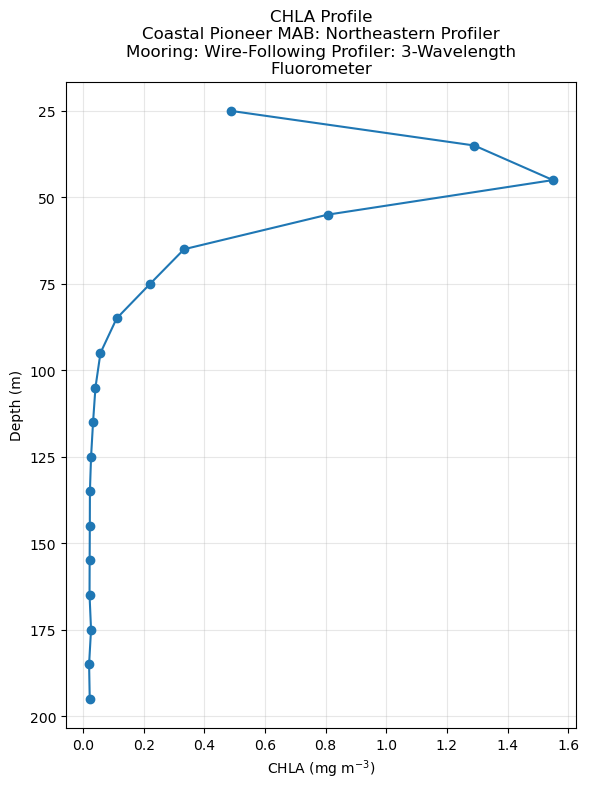

In [75]:
# Create a plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import textwrap

# ---- 1. Load combined dataset ----
combined_path = Path("_temp_data/ooi_chla_0_200m.parquet")
df = pd.read_parquet(combined_path)

# Ensure time is datetime (not strictly needed for the plot, but nice to have)
df["time"] = pd.to_datetime(df["time"])

# ---- 2. Identify CHLA columns and pick a good profile ----
chla_cols = [c for c in df.columns if c.startswith("CHLA_")]

if not chla_cols:
    raise ValueError("No CHLA_ columns found in the dataframe.")

# Count how many non-NaN CHLA values each profile_id has (per row)
# (Assumes one row per profile_id; if multiple, takes the max across rows.)
counts = (
    df.groupby("profile_id")[chla_cols]
      .apply(lambda x: x.notna().sum(axis=1).max())
)

# Get a profile_id with at least 10 valid CHLA bins
valid_profiles = counts[counts >= 10]
if valid_profiles.empty:
    raise ValueError("No profile_id found with at least 10 non-NaN CHLA bins.")

rand_row = valid_profiles.sample(1, random_state=None)  # set an int seed if you want reproducible

profile_id = rand_row.index[0]
n_bins = rand_row.iloc[0]

print(f"Using profile_id: {profile_id} with {n_bins} valid CHLA bins")

# Get Description
desc = df.loc[df["profile_id"] == profile_id, "description"].iloc[0]

# ---- 3. Extract that profile ----
sub = df[df["profile_id"] == profile_id].copy()

# If there somehow are multiple rows for this profile, average them
if len(sub) > 1:
    sub = sub.groupby("profile_id")[chla_cols].mean().reset_index()
else:
    sub = sub.reset_index(drop=True)

# Take the first (or only) row of CHLA values
chla_vals = sub[chla_cols].iloc[0].values

# ---- 4. Build depth midpoints from CHLA_0_10 style column names ----
# CHLA_0_10 -> lower edge = 0 -> midpoint = 5
depths = []
for col in chla_cols:
    # col format assumed: "CHLA_<z1>_<z2>"
    parts = col.split("_")
    if len(parts) < 3:
        raise ValueError(f"Unexpected CHLA column format: {col}")
    z1 = int(parts[1])
    z_mid = z1 + 5  # 10 m bin midpoint
    depths.append(z_mid)

depths = np.array(depths)
chla_vals = np.array(chla_vals, dtype=float)

# Sort by depth (just in case columns are out of order)
order = np.argsort(depths)
depths = depths[order]
chla_vals = chla_vals[order]

# Mask out NaNs so the plot doesn't connect them
valid = ~np.isnan(chla_vals)
depths_valid = depths[valid]
chla_valid = chla_vals[valid]

# ---- 5. Plot CHLA vs depth ----
plt.figure(figsize=(6, 8))
plt.plot(chla_valid, depths_valid, marker="o")

plt.gca().invert_yaxis()  # surface at top
plt.xlabel("CHLA (mg m$^{-3}$)")
plt.ylabel("Depth (m)")
wrapped_desc = textwrap.fill(desc, width=50)  # adjust width to taste
plt.title(f"CHLA Profile\n{wrapped_desc}")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Match ups to PACE

In [76]:
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/fish-pace-datasets/ml_utils.py'>

In [ ]:
# Load data from GitHub
df_y_name="CHLA"; df_lat_name="lat"; df_lon_name="lon"; df_time_name="time"
import pandas as pd
base_url="https://raw.githubusercontent.com/fish-pace/fish-pace-datasets/main/data/ooi_profiles.parquet"
url = f"{base_url}argo_profiles_index.parquet"
argo_chl_df = pd.read_parquet(url)
len(argo_chl_df)

In [77]:
%%time
from datetime import datetime

def run_batch(
    results, df, 
    ds_vec_name="wavelength", ds_var_name="Rrs", ds_vec_sel=None,
    df_time_name="time", df_lat_name="lat", df_lon_name="lon"
):
    """
    Run a batch of PACE files (results) and return PACE variables for lat/lon/time rows in a
    dataframe.

    Parameters
    ----------
    results : earthaccess results object as returned by `earthaccess.search`). 
    
    df : A pandas DataFrame containing Argo observations. Must include columns for
        time, latitude, longitude.

    ds_vec_name : str or None, optional
        Name of the spectral dimension in the PACE dataset (e.g. "wavelength").
        If not None, matched satellite spectra are returned with one column per
        wavelength. If None, only a single variable is extracted.

    ds_vec_sel : value or None, optional
        Value of the spectral dimension in the PACE dataset (e.g. "wavelength")
        to select. If None, matched satellite spectra are returned with one column per
        wavelength. If given, only a single variable is extracted for that value.

    ds_var_name : str, optional
        Name of the variable to extract from the PACE dataset
        (e.g. "Rrs" or "chlor_a").

    df_lat_name, df_lon_name, df_time_name : str, optional
        Column names in `df` for latitude, longitude, and time.
    """

    # Make sure to refresh fileset to minimize the chance that the token expires before we are done
    # this for loop consumes about 6Gb of RAM
    fileset = earthaccess.open(results, pqdm_kwargs={"disable": True} );
    
    df_plus = []
    for i, f in enumerate(fileset):
        df_record, pts = mu.one_file_matches(
            f, df, 
            ds_vec_name=ds_vec_name, ds_var_name=ds_var_name, ds_vec_sel=ds_vec_sel,
            df_time_name=df_time_name, df_lat_name=df_lat_name, df_lon_name=df_lon_name)
        if df_record is None or len(df_record) == 0: 
            print(f"Skipped day {i} no data in df")
            continue
        # error check
        if len(df_record) != len(pts):
            raise ValueError(f"Row mismatch: df_record={len(df_record)}, pts={len(pts)}")
    
        # left "concat": keep df_record rows, add pts columns by position
        df_record_plus = pd.concat(
            [ 
                df_record.reset_index(drop=True), 
                pts.reset_index(drop=True),
            ], axis=1,)
        df_plus.append(df_record_plus)
    if not len(df_plus) == 0:
        df_plus = pd.concat(df_plus, ignore_index=True)
    return df_plus

CPU times: user 11 μs, sys: 1e+03 ns, total: 12 μs
Wall time: 15.7 μs


In [ ]:
# Load data from GitHub
df_y_name="CHLA"; df_lat_name="LATITUDE"; df_lon_name="LONGITUDE"; df_time_name="TIME"
import pandas as pd
base_url="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/data/argo_monthly_nc/"
url = f"{base_url}argo_profiles_index.parquet"
argo_chl_df = pd.read_parquet(url)
len(argo_chl_df)

## Get Rrs

In [78]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
df = argo_chl_df
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (df.TIME.min(), df.TIME.max()),
    granule_name="*.DAY.*.4km.*"
)
rrs_results_nrt = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS_NRT",
    temporal = (df.TIME.min(), df.TIME.max()),
    granule_name="*.DAY.*.4km.*"
)
results = rrs_results + rrs_results_nrt
print(f"{len(results)} days of PACE data")

NameError: name 'argo_chl_df' is not defined

In [ ]:
from pathlib import Path
from datetime import datetime
import pandas as pd

results_dir = Path("_temp_data/matchups")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "OOI"
results = results
df = argo_chl_df
ds_var = "Rrs"

for batch_idx, i in enumerate(range(0, len(results), batch_size), start=1):
    batch = results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files: {datetime.now():%H:%M:%S}")

    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_{ds_var}_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    df_batch = run_batch(batch, df)  # returns a DataFrame

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")